In [1]:
#@title Importing Libraries

# numerical operations
import numpy as np

# used for plotting
import matplotlib.pyplot as plt

# used for calculating distances
from scipy.spatial import distance

In [2]:
#@title Defining Known Land Mass Points

# A dictionary where each key is a continent and the value is a list of tuples
# representing points on that continent.

land_points = {
    'South America': [(-30, -60), (-15, -50), (0, -45), (15, -30), (30, -20)],
    'Australia': [(50, 10), (55, 0), (60, 10), (65, 20), (70, 30)],
    'Asia': [(20, 60), (30, 70), (40, 80), (50, 90), (60, 100)],
    'Africa': [(0, 20), (10, 20), (20, 30), (30, 40), (40, 50)],
    'Europe': [(-35, 140), (-30, 145), (-25, 150), (-20, 155), (-15, 160)]
}

In [3]:
#@title Defining a Grid of Points

# Create a grid of points with latitude ranging from -90 to 90 and longitude
# from -180 to 180 in steps of 10.

grid_points = [(x, y) for x in range(-90, 91, 10) for y in range(-180, 181, 10)]

In [4]:
#@title Calculating Prior Probabilities

# This function calculates the prior probabilities of a point being land or sea based on
# the number of land points versus the total points.

def calculate_prior_probabilities(land_points, total_points):
    P_land = sum(len(points) for points in land_points.values()) / total_points
    P_sea = 1 - P_land

    return P_land, P_sea


In [5]:
#@title Calculating Likelihoods

# This function calculates the likelihoods of points being land or sea based on their distances
# to the nearest land point.

# The likelihood decreases exponentially with increasing distance from land.

def calculate_likelihoods(grid_points, land_points):
    likelihoods_land = {}
    likelihoods_sea = {}

    all_land_points = [point for points in land_points.values() for point in points]

    for point in grid_points:
        distances_to_land = distance.cdist([point], all_land_points, 'euclidean').min()
        likelihoods_land[point] = np.exp(-distances_to_land)  # Exponential decay
        likelihoods_sea[point] = 1 - likelihoods_land[point]  # Opposite of land

    return likelihoods_land, likelihoods_sea

In [6]:
##MODIFYING THE CLASSIFY POINT FUNCTION
def classify_point(point, box_bounds, coastline_threshold=10):
    x, y = point
    x_min, x_max, y_min, y_max = box_bounds
#checks if points are within the bounding box) 
    if x_min <= x <= x_max and y_min <= y <= y_max:
        all_land_points = [p for points in land_points.values() for p in points]
        distances_to_land = distance.cdist([point], all_land_points, 'euclidean').min()
        
        if distances_to_land <= coastline_threshold:
            return 'Coastline'
        else:
            return 'Land'
    else:
        # If outside the bounding box, it's sea
        return 'Sea'



In [7]:
##UPDATING THE PLOTTING POINTS

def plot_points(land_points, test_points, test_classifications, box_bounds, coastline_points):
    fig, ax = plt.subplots()

    # Define colors for each continent and classification
    continent_colors = {
        'South America': 'green',
        'Europe': 'red',
        'Asia': 'blue',
        'Africa': 'purple',
        'Australia': 'orange'
    }
    classification_colors = {
        'Land': 'green',
        'Sea': 'blue',
        'Coastline': 'cyan'  # New color for Coastline
    }

    # Plot land points by continent
    for continent, points in land_points.items():
        land_x, land_y = zip(*points)
        ax.scatter(land_x, land_y, color=continent_colors[continent], label=f'{continent}')

    # Highlight land model with an orange box
    x_min, x_max, y_min, y_max = box_bounds
    land_model_x = [x_min, x_max, x_max, x_min, x_min]
    land_model_y = [y_min, y_min, y_max, y_max, y_min]
    ax.plot(land_model_x, land_model_y, color='orange', label='Land Model')

    # Plot test points with updated classification
    for point, classification in zip(test_points, test_classifications):
        color = classification_colors[classification]  # Use new color scheme
        ax.scatter(point[0], point[1], color=color, edgecolors='red', label=f'Test Point ({classification})')

    # Plot coastline points
    coastline_x, coastline_y = zip(*coastline_points)
    ax.scatter(coastline_x, coastline_y, color='cyan', edgecolors='black', label='Coastline')

    # Place the legend outside the plot box
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Land, Sea, and Coastline Points with Model')
    plt.grid(False)  # Remove grid
    plt.show()



Test Point Classifications:
Point (-20, -40): Land
Point (20, 75): Land
Point (50, 50): Coastline
Point (-30, 160): Land
Point (80, -170): Sea
Point (-55, 150): Sea
Point (55, 15): Coastline
Point (15, 25): Coastline
Point (61, 102): Coastline


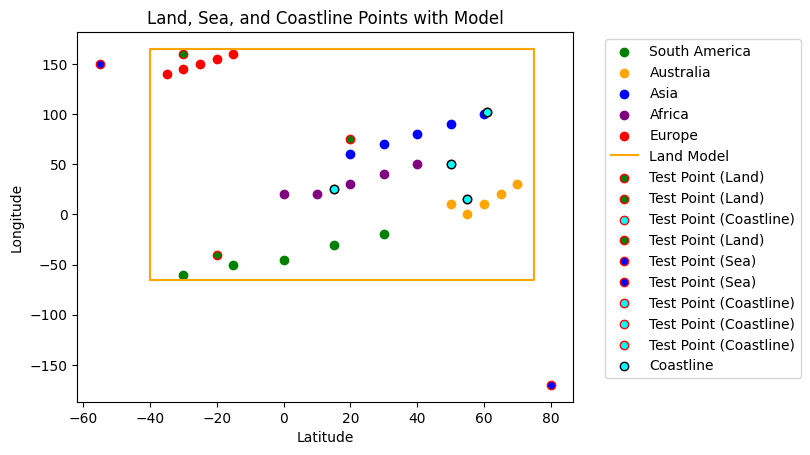

In [9]:
#@title Main Execution

# This section calculates the total grid points, prior probabilities, likelihoods,
# defines the model box, classifies test points, prints the classifications, and
# plots the points and the model.

# Total points in the grid
total_points = len(grid_points)

# Calculate prior probabilities
P_land, P_sea = calculate_prior_probabilities(land_points, total_points)

# Calculate likelihoods
likelihoods_land, likelihoods_sea = calculate_likelihoods(grid_points, land_points)

# Define the bounds of the model box
all_land_x = [point[0] for points in land_points.values() for point in points]
all_land_y = [point[1] for points in land_points.values() for point in points]
x_min, x_max = min(all_land_x) - 5, max(all_land_x) + 5
y_min, y_max = min(all_land_y) - 5, max(all_land_y) + 5
box_bounds = (x_min, x_max, y_min, y_max)

# Adding points to the testing 
test_points = [
    (-20, -40), (20, 75), (50, 50), (-30, 160), (80, -170), (-55, 150), (55,15), (15,25), (61,102),
]

coastline_threshold = 10

# Classify test points 
test_classifications = [classify_point(point, box_bounds, coastline_threshold) for point in test_points]

# Define coastline points for plotting
coastline_points = [point for point in test_points if classify_point(point, box_bounds, coastline_threshold) == 'Coastline']

# Print test point classifications
print("\nTest Point Classifications:")
for point, classification in zip(test_points, test_classifications):
    print(f"Point {point}: {classification}")

# Plot the points and the model with updated classifications
plot_points(land_points, test_points, test_classifications, box_bounds, coastline_points)
